<a href="https://colab.research.google.com/github/91htjung/AirportBusinessAnalytics/blob/main/01-Forecast_Longterm_Econometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with Python
Welcome to Airport Business Analytics Course.

In this exercise, we will use Google Colab to run the forecast using Python programming Language.

There are two different exercise, one with a long-term forecast (10 years) using log-log regression model, and the other with a short-term forecast (24 months) using ARIMA model.


1.   01-Forecast_Longterm_Econometric
2.   02-Forecast_Shortterm_Statistics

Before moving on, please read the following "Getting started" block for generic introduction of Google Colab.

# Getting started
The document you are reading is not a static web page, but an interactive environment called a Colab notebook that lets you write and execute code.

For example, here is a code cell with a short Python script that computes a value, stores it in a variable, and prints the result:

In [1]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [2]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

**Comment**: a sentence or block of text that is not executed as part of the code.
Comments in Python is the inclusion of short descriptions along with the code to increase its readability. A developer uses them to write his or her thought process while writing the code.

Single-line comments begin with the “#” character. Anything that is written in a single line after ‘#’ is considered as a comment. The syntax for writing single-line comments is:


```
# This is an example of Single-line comments; a line after the "#" symbol will not be executed in the cell.

# You can easily distinguish Single-line comments by seeing the green text.
```



In the exercise, the single-line comment is used to help readers to understand the code.

# In this module you will learn how to:

1.   Interact with Pandas library, reading and transforming the dataset
2.   Split our data into train-test samples
3.   Train a linear regression model and test the result
4.   Perform a 10-years forecast using the trained model.


# Setting up the environment

To perform forecasting in Python, we will need to install packages - a collection of Python modules, functions, classes, and variables that can be utilized in other Python programs. Packages provide a structured way to organize and distribute Python code, making it easier for developers to manage and reuse code across different projects.

Here, simply run the cell below by using the keyboard "Ctrl+Enter". The code will be executed and necessary packages will be installed.

In [6]:
# Importing necessary packages to run the cells below
import pandas as pd
import numpy as np
import warnings

try:
    import sktime
    import sklearn
    import seaborn as sns
except:
    !pip install --root-user-action=ignore -q ../input/aci-airport-business-analytics-doha/scikit_base-0.11.0-py3-none-any.whl
    !pip install --root-user-action=ignore -q ../input/aci-airport-business-analytics-doha/sktime-0.34.0-py3-none-any.whl
    import sktime
    import sklearn
    import seaborn as sns

sns.set(rc={'figure.figsize':(12,4)})
warnings.filterwarnings("ignore")

In this exercise, we will use scikit-learn (sklearn) and sktime library to perform forecasting.

# Reading data

Let's read a dummy data. The dataset can be read by the code below. Similarly, use keyboard "Ctrl+Enter" to run the cell below.

In [9]:
# Reading a CSV file into dataset variable
dataset = pd.read_csv('../input/aci-airport-business-analytics-doha/ABA-DOH-Data_Longterm_Econometric.csv')
# Parse the Period column into annual period format and use it as an index of the table
dataset['Period'] = pd.to_datetime(dataset['Period'])
dataset = dataset.set_index(['Period']).to_period("A")
dataset

,Passenger,GDP,Population
Period,,,
2006,4.560756e+09,60994370,6611696
2007,4.908389e+09,63571790,6693580
2008,4.923149e+09,64786270,6776098
2009,4.832530e+09,63629480,6858496
2010,5.282775e+09,66415110,6941248
2011,5.654991e+09,68548300,7024048
2012,5.991817e+09,70249140,7108029
2013,6.392540e+09,72079680,7193107
2014,6.778575e+09,74103710,7278136


The dataset is made up with historic annual Passenger, GDP, and Population statistics:

1.   **Historic** Passenger (2006 - 2019)
2.   **Historic** GDP (2006 - 2019)
3.   **Historic** Population (2006 - 2019)

And forecasted GDP and Population statistics.

4.   **Forecast** GDP (2020 - 2033)
5.   **Forecast** Population (2020 - 2033)

Our goal is to perform the forecast of passenger number between 2020-2033, using the historical passenger traffic and forecasted GDP and Population statistics.

In this context, we are performing a multivariate forecast using GDP and Population as **exogenous variables**. The passenger number is called **endogenous variables**.

# Visualizing data

A great way to begin our examination of the truth would be to visualize the relationship through a chart. We will use seperate line charts to visualize each variables.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Population'>)

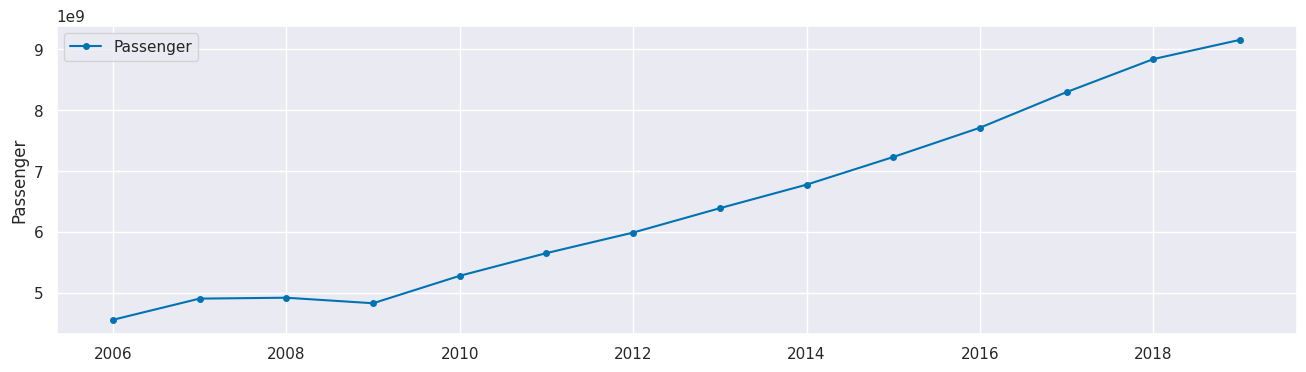

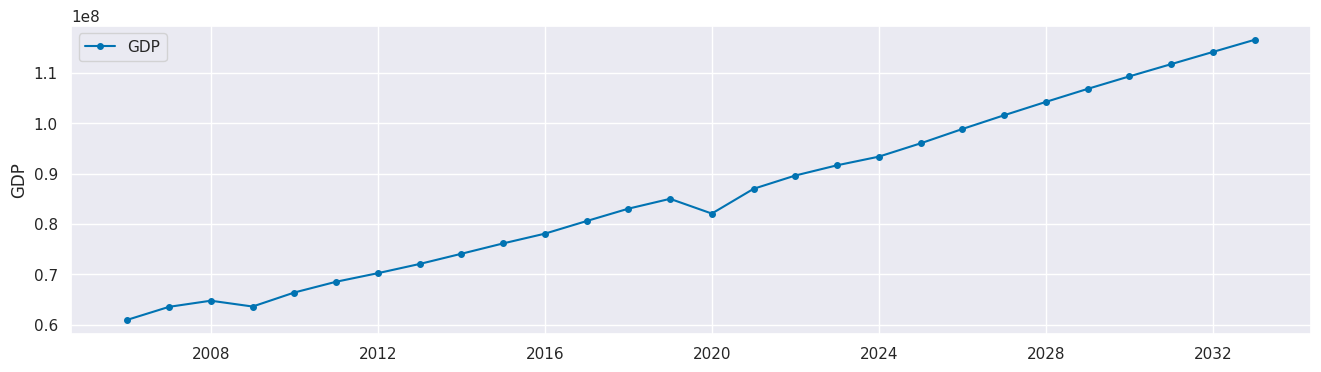

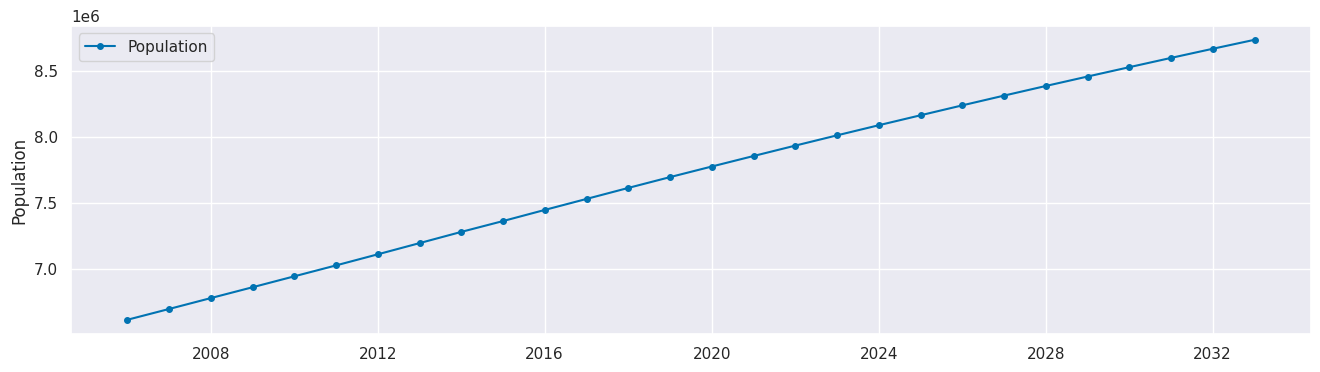

In [10]:
from sktime.utils.plotting import plot_series

# plotting the raw dataset to understand its characteristics
plot_series(dataset['Passenger'], labels=['Passenger'])
plot_series(dataset['GDP'], labels=['GDP'])
plot_series(dataset['Population'], labels=['Population'])

# Log transformation

Let's assume that we are going to use the **log-log model** - which is one of the most widely-used model in economic analyses. The detailed explanation of log-log model, please review the materials in **Module 4**.

Before training the linear regression, we need to transform each variables into log. The cell below is the transformation process. We will add new columns of log-transformed variables ("Passenger_log", "GDP_log", and "Population_log").

In [11]:
# log-transforming columns using numpy
dataset['Passenger_log'] = np.log(dataset['Passenger'])
dataset['GDP_log'] = np.log(dataset['GDP'])
dataset['Population_log'] = np.log(dataset['Population'])
dataset

,Passenger,GDP,Population,Passenger_log,GDP_log,Population_log
2006,4.560756e+09,60994370,6611696,22.240754,17.926292,15.704351
2007,4.908389e+09,63571790,6693580,22.314212,17.967680,15.716659
2008,4.923149e+09,64786270,6776098,22.317214,17.986604,15.728912
2009,4.832530e+09,63629480,6858496,22.298636,17.968587,15.740999
2010,5.282775e+09,66415110,6941248,22.387717,18.011435,15.752992
2011,5.654991e+09,68548300,7024048,22.455804,18.043049,15.764850
2012,5.991817e+09,70249140,7108029,22.513661,18.067559,15.776736
2013,6.392540e+09,72079680,7193107,22.578397,18.093283,15.788634
2014,6.778575e+09,74103710,7278136,22.637033,18.120976,15.800385
2015,7.232229e+09,76159300,7360282,22.701813,18.148338,15.811609


# Separation of Historic and Forecast section

Since the provided time-seris dataset has both historic data (2006 - 2019) and forecasted data (2020 - 2033), we will separate them into two groups.

The historic data will be used in fitting the forecasting model and the forecast data will be used in generating passenger number forecast from the fitted model.

In [12]:
# splitting historic data (periods up until the Passenger data exists) and forecasting (periods where only GDP and Population exist, but not Passenger data)
historic = dataset[(dataset.index <= pd.Period('2019-12-01', freq='A'))]
forecast = dataset[(dataset.index > pd.Period('2019-12-01', freq='A'))]

The historic dataset looks alike:

In [13]:
historic

,Passenger,GDP,Population,Passenger_log,GDP_log,Population_log
2006,4.560756e+09,60994370,6611696,22.240754,17.926292,15.704351
2007,4.908389e+09,63571790,6693580,22.314212,17.967680,15.716659
2008,4.923149e+09,64786270,6776098,22.317214,17.986604,15.728912
2009,4.832530e+09,63629480,6858496,22.298636,17.968587,15.740999
2010,5.282775e+09,66415110,6941248,22.387717,18.011435,15.752992
2011,5.654991e+09,68548300,7024048,22.455804,18.043049,15.764850
2012,5.991817e+09,70249140,7108029,22.513661,18.067559,15.776736
2013,6.392540e+09,72079680,7193107,22.578397,18.093283,15.788634
2014,6.778575e+09,74103710,7278136,22.637033,18.120976,15.800385
2015,7.232229e+09,76159300,7360282,22.701813,18.148338,15.811609


and the forecast dataset looks alike:

In [14]:
forecast

,Passenger,GDP,Population,Passenger_log,GDP_log,Population_log
2020,NaN,82084330,7773787,NaN,18.223258,15.866268
2021,NaN,87006610,7853534,NaN,18.281495,15.876474
2022,NaN,89641680,7932355,NaN,18.311331,15.886461
2023,NaN,91669540,8010128,NaN,18.333701,15.896217
2024,NaN,93382260,8086800,NaN,18.352212,15.905744
2025,NaN,96030220,8162399,NaN,18.380173,15.915049
2026,NaN,98872030,8237484,NaN,18.409337,15.924206
2027,NaN,101601800,8311435,NaN,18.436572,15.933143
2028,NaN,104249300,8384303,NaN,18.462296,15.941872
2029,NaN,106838000,8456150,NaN,18.486824,15.950405


# Training and test data splitting

Remember that when we are using data-driven techniques, we need to split our sample into a training/test set.

*   **Training set**: subset of the data used to develop models (learn)
*   **Test set**: subset of the data used to test the models (ensure you learned the right thing)

Here, we will use 75% and 25% to split the model without shuffling, so that the later 4 years will be used as a testing dataset.

In [15]:
from sklearn.model_selection import train_test_split

# X: Exogenous variables (GDP and Population)
# y: Endogenous variable (Passenger) - forecast target
y = pd.DataFrame(historic[['Passenger_log']])
X = historic[['GDP_log', 'Population_log']]

# Splitting train and test data by ratio of 75% and 25% from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25)

Note that our prediction variable is **Passenger_log**, hence denoted as **y**.

**GDP_log** and **Population_log** are exogeneous variables (which are used to build a prediction, but not prediction variables themselves), and denoted as **X**.

log-log model denotation:

$log(y)=\alpha +\beta_1log(X_1)+\beta_2log(X_2)$

To apply the equation above, the mathematical expression of our model will be:

$log(Passengers)=\alpha +\beta_1 log(GDP)+\beta_2 log(Population)$


Let's see the splitted dataset (y_train, y_test, X_train, and X_test) below.

In [16]:
# y_train: the first 75% of historical passenger data that will be used in model training
y_train

,Passenger_log
2006,22.240754
2007,22.314212
2008,22.317214
2009,22.298636
2010,22.387717
2011,22.455804
2012,22.513661
2013,22.578397
2014,22.637033
2015,22.701813


In [19]:
# y_train: the last 25% of historical passenger data that will be used in model testing
y_test

,Passenger_log
2016,22.766103
2017,22.839384
2018,22.902495
2019,22.937582


In [20]:
# X_train: the first 75% of historical GDP and Population data that will be used in model training
X_train

,GDP_log,Population_log
2006,17.926292,15.704351
2007,17.967680,15.716659
2008,17.986604,15.728912
2009,17.968587,15.740999
2010,18.011435,15.752992
2011,18.043049,15.764850
2012,18.067559,15.776736
2013,18.093283,15.788634
2014,18.120976,15.800385
2015,18.148338,15.811609


In [21]:
# X_test: the last 25% of historical GDP and Population data that will be used in model testing
X_test

,GDP_log,Population_log
2016,18.173391,15.822998
2017,18.205013,15.834164
2018,18.235028,15.845176
2019,18.258307,15.855886


We see that the training data (2006 - 2015) and test data (2016 - 2019) have been splitted.

# Training the model

Now we will build a LinearRegression model using sklearn package. sklearn offers pre-built classes and functions that are needed in ordinary Linear Regression tasks.

To import the LinearRegression model, run the cell below.

In [22]:
from sklearn.linear_model import LinearRegression

# importing pre-built Linear Regression class from sklearn package
regressor = LinearRegression()

To train the imported regressor, we use .fit() function with two variables - X_train (GDP and Population) and y_train (Passenger numbers).

In [23]:
# fitting (training) the model using the training dataset
regressor.fit(X_train, y_train)

LinearRegression()

The regressor has been trained. To get the parameters (coefficients and intercept), we can call them by using the following attributes:


*   **.coef_** : coefficient
*   **.intercept_**: intercept

The coefficient here means $\beta_1$ and $\beta_2$, and the intercept is $\alpha$ from the equation below.

$log(Passengers)=\alpha +\beta_1 log(GDP)+\beta_2 log(Population)$




In [24]:
# coefficient of the trained model. beta_1 and beta_2 in the equation above.
regressor.coef_

array([[ 2.36321502, -0.44297159]])

In [25]:
# intercept of the trained model. alpha in the equation above.
regressor.intercept_

array([-13.19161365])

Therefore, from the training data, the fitted parameters can be expressed as:

$log(Passengers)=(-13.1916) + (2.3632) \times log(GDP)+ (-0.4429) \times log(Population)$


# Test the model

From the trained model, we will evaluate whether the model works well using the test dataset.

The prediction will be generated by inputting X_test variables to the fitted regressor.

To make a prediction, run the following cell.

In [26]:
y_pred = regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=['Passenger_log'])
y_pred

,Passenger_log
2016,22.746878
2017,22.816663
2018,22.882717
2019,22.932984


Note that we have log-transformed the Passenger data.

To evaluate the regression model with actual numbers, we will perform inverse log-transform the **Passenger_log** into **Passenger**, by using np.exp() function.

If the model is trained well, the difference between prediction (y_pred) and actual historical data (y_test) will be small.

Let's first visualize the dataset to see the difference.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Passenger_log'>)

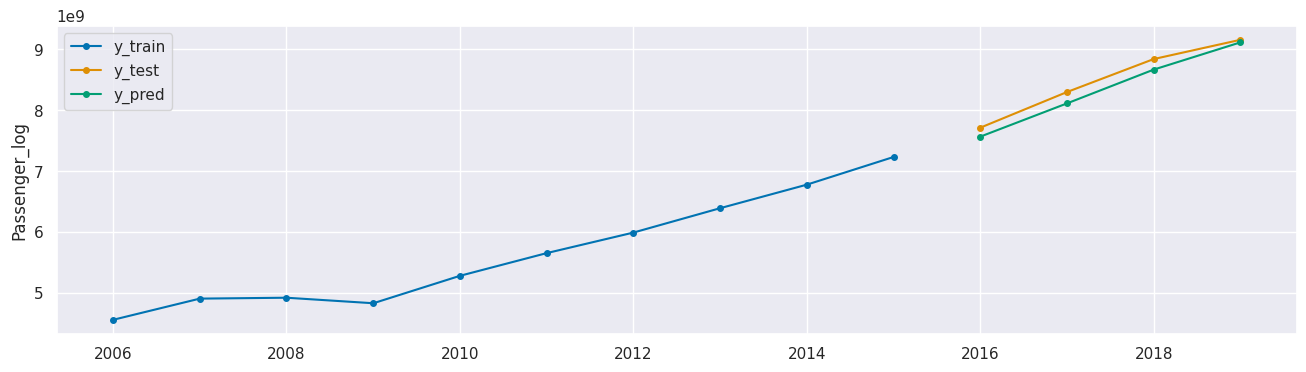

In [27]:
# plotting the training data, test data, and predicted result at the same time. If the model has a fair accuracy, we expect the gap between test and prediction to close.
# since the y_train, y_test, and y_pred are log-transformed, we will inverse transform by using np.exp() function.
plot_series(np.exp(y_train), np.exp(y_test), np.exp(y_pred), labels=["y_train", "y_test", "y_pred"])

By looking at the chart, we could observe that the prediction captured the overall trend.

To measure the accuracy of the model, we will calculate **MAPE** (Mean Absolute Percentage Error), by running the cell below.

In [28]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# The lower the MAPE, the better the accuracy is.
print('MAPE: %.4f' % mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred), symmetric=False))

MAPE: 0.0164


The MAPE indicates that the accuracy of the model is measured to be 1.64%.

# Perform forecast

Let's assume that we are satisfied with 1.64% of MAPE.

With the given trained log-log regression model, we will now perform forecast of **Passengers (2020 - 2033)**, using the **GDP and Population forecast (2020 - 2033)** as exogenous variables.

We will define the forecasted GDP_log and Population_log as **X2**.

In [29]:
# log-transformed GDP and Population of 2020 ~ 2033
X2 = forecast[['GDP_log', 'Population_log']]
X2

,GDP_log,Population_log
2020,18.223258,15.866268
2021,18.281495,15.876474
2022,18.311331,15.886461
2023,18.333701,15.896217
2024,18.352212,15.905744
2025,18.380173,15.915049
2026,18.409337,15.924206
2027,18.436572,15.933143
2028,18.462296,15.941872
2029,18.486824,15.950405


Then, we will make a prediction with new X2, denoted as y2_pred.

In [30]:
# make a prediction of new exogenous variables into fitted regressor
y2_pred = regressor.predict(X2)
y2_pred = pd.DataFrame(y2_pred, index=X2.index, columns=['Passenger_log'])
y2_pred

,Passenger_log
2020,22.845557
2021,22.978662
2022,23.044748
2023,23.093291
2024,23.132817
2025,23.194774
2026,23.259637
2027,23.320040
2028,23.376965
2029,23.431151


We will visualize the historic passenger number and forecasted passenger number.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Passenger_log'>)

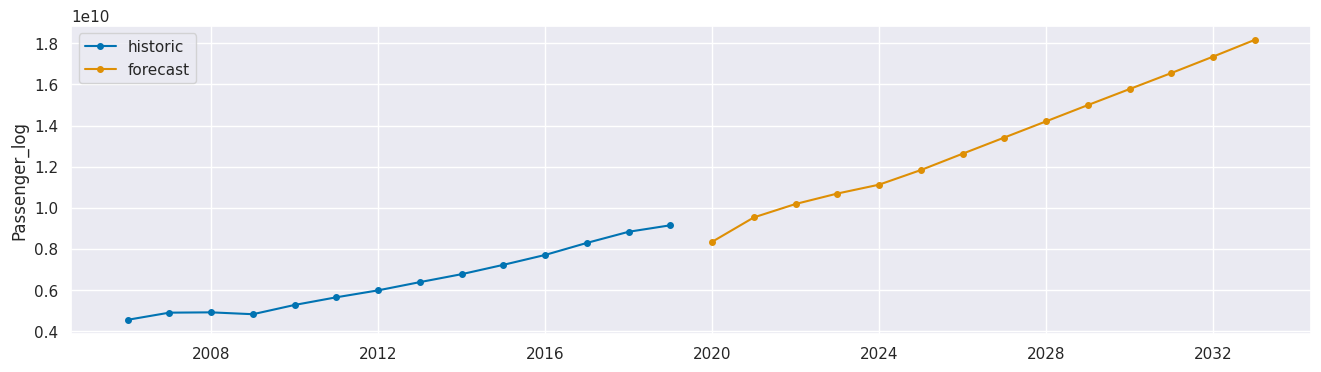

In [31]:
# plotting the historic data and forecast together.
# since the y and y2_pred are log-transformed, we will inverse transform by using np.exp() function.
plot_series(np.exp(y), np.exp(y2_pred), labels=["historic", "forecast"])

To export the forecasted value, we can add as a new column of the dataset.

In [32]:
# attaching the prediction result as a new column in dataset table
dataset['Passenger_forecast'] = np.exp(y2_pred)
dataset

,Passenger,GDP,Population,Passenger_log,GDP_log,Population_log,Passenger_forecast
2006,4.560756e+09,60994370,6611696,22.240754,17.926292,15.704351,NaN
2007,4.908389e+09,63571790,6693580,22.314212,17.967680,15.716659,NaN
2008,4.923149e+09,64786270,6776098,22.317214,17.986604,15.728912,NaN
2009,4.832530e+09,63629480,6858496,22.298636,17.968587,15.740999,NaN
2010,5.282775e+09,66415110,6941248,22.387717,18.011435,15.752992,NaN
2011,5.654991e+09,68548300,7024048,22.455804,18.043049,15.764850,NaN
2012,5.991817e+09,70249140,7108029,22.513661,18.067559,15.776736,NaN
2013,6.392540e+09,72079680,7193107,22.578397,18.093283,15.788634,NaN
2014,6.778575e+09,74103710,7278136,22.637033,18.120976,15.800385,NaN
2015,7.232229e+09,76159300,7360282,22.701813,18.148338,15.811609,NaN


To export the DataFrame (dataset variable), you can run the cell below.

In [36]:
import os
os.chdir(r'../working')

dataset.to_csv(r'dataset.csv')

from IPython.display import FileLink
FileLink(r'dataset.csv')

/kaggle/working/dataset.csv